본 코드는 ImageNet 데이터에 대하여 PGD 기반의 Perturbation 공격을 수행하는 과정과 결과를 보여준다.

# Dependencies and Imports

In [1]:
# Install requirements
%pip install torchattacks

# Create a directory to store our results
# ! mkdir 


[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os

import torch
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision
from torchvision import transforms
from torchvision import models
from torchvision.models import ResNet18_Weights,ResNet34_Weights,ResNet50_Weights,ResNet101_Weights,ResNet152_Weights
import torchvision.datasets as dsets

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torchattacks
from torchattacks import PGD

# Display Utils

In [3]:
# Functions to show an image
def imshow(img, title):
    img = torchvision.utils.make_grid(img.cpu().data, normalize=True).permute(1,2,0)
    plt.imshow(img)
    plt.title(title)
    plt.show()

# Load Model and Data

공격 대상이 되는 객체 분류용 AI 모델로는 pre-trained ResNet-152를 사용하였다.
해당 모델은 ImageNet LSVRC 2012 Validation Set에 대해 약 82.1%의 분류 정확도를 보였다.

In [4]:
# Load a pretrained model
# model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
# or any of these variants
# model = models.resnet34(weights=ResNet34_Weights.DEFAULT)
# model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
# model = models.resnet101(weights=ResNet101_Weights.DEFAULT)
model = models.resnet152(weights=ResNet152_Weights.DEFAULT)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [5]:
# Data augmentation
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD),
])

# Load ImageNet Data
DSET_SIZE=50000
TRAIN_SIZE=4000
TEST_SIZE=1000

index = np.arange(DSET_SIZE)
np.random.shuffle(index)
train_index = index[:TRAIN_SIZE]
test_index = index[TRAIN_SIZE: (TRAIN_SIZE + TEST_SIZE)]

BATCH_SIZE=256

train_set = dsets.ImageFolder(root='./ILSVRC2012_img_val', transform=preprocess)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, sampler=SubsetRandomSampler(train_index), shuffle=False)
test_set = dsets.ImageFolder(root='./ILSVRC2012_img_val', transform=preprocess)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, sampler=SubsetRandomSampler(test_index), shuffle=False)

# Download ImageNet labelss
# %wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

# Read the categories
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]


# move the model to GPU for speed if available
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
model = model.to(device)

In [6]:
# Test model accuracy
correct,total=0,0
with torch.no_grad():
    for images,labels in test_loader:
        images=images.to(device)
        labels=labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(1, keepdim = True)
        correct += preds.eq(labels.view_as(preds)).sum()
        total += labels.shape[0]
print(f"model accuracy: {100 * correct / total}")

model accuracy: 82.10000610351562


# Attack

아래의 코드는 ImageNet 데이터에 있는 hard disc 이미지에 대해 Perturbation 공격을 수행하였더니
본래의 이미지는 hard disc라고 인식하는 반면, Perturbated 이미지는 스컹크로 인식함을 보여준다.  
본래의 이미지와 Perturbated 이미지는 육안으로 거의 구분될 수 있음을 확인 할 수 있다.

In [96]:
# Choose a baseline image
image_set = dsets.ImageFolder(root='./ILSVRC2012_img_val', transform=preprocess)
image_loader = torch.utils.data.DataLoader(train_set, batch_size=1,shuffle=True)
imageiter = iter(image_loader)
images, labels = next(imageiter)
images=images.to(device)
labels=labels.to(device)

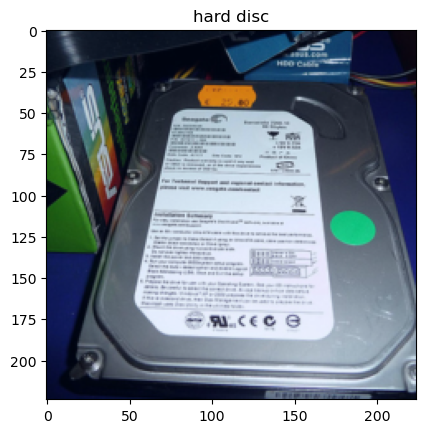

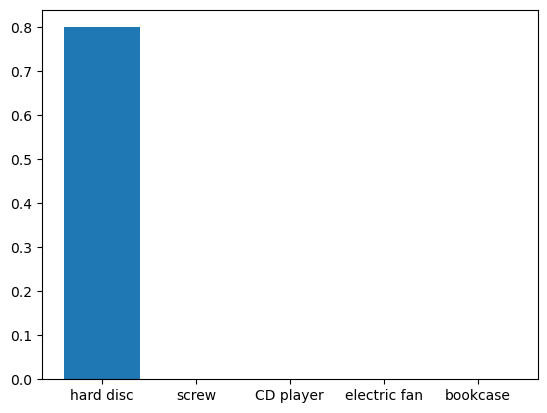

In [97]:
# Orinal prediction
imshow(images,categories[labels.item()])
with torch.no_grad():
    outputs = model(images)
probabilities = torch.nn.functional.softmax(outputs[0], dim=0)

# Show top categories of original image
top5_prob, top5_catid = torch.topk(probabilities, 5)
x = np.arange(5)
top5_categories=[]
top5_probabilities=[]
for i in range(top5_prob.size(0)):
    top5_categories.append(categories[top5_catid[i]]) 
    top5_probabilities.append(top5_prob[i].item())
plt.bar(x, top5_probabilities)
plt.xticks(x, top5_categories)
plt.show()



Perturbation Attack
PGD(model_name=ResNet, device=mps:0, attack_mode=default, targeted=False, normalization_used=True, eps=0.03137254901960784, alpha=0.008888888888888889, steps=10, random_start=True)


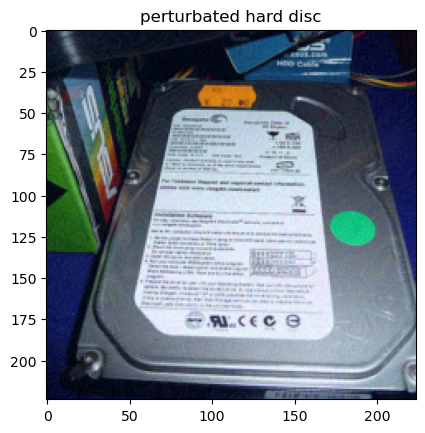

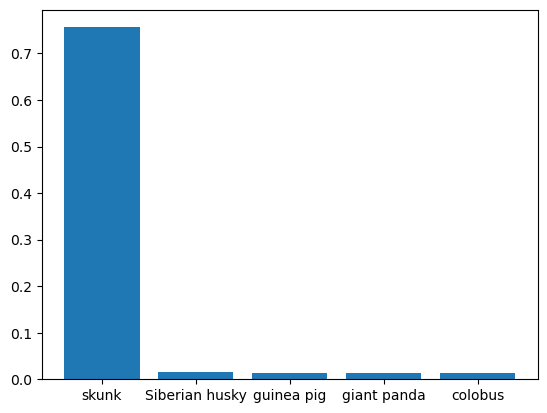

In [98]:
# Perform an attack
atk = PGD(model, eps=8/255, alpha=2/225, steps=10, random_start=True)
atk.set_normalization_used(mean=MEAN, std=STD)
print('Perturbation Attack')
print(atk)
perturbated_images = atk(images, labels)

# Perturbated prediction
imshow(perturbated_images,'perturbated '+categories[labels.item()])
with torch.no_grad():
    outputs = model(perturbated_images)
probabilities = torch.nn.functional.softmax(outputs[0], dim=0)

# Show top categories of perturbated image
top5_prob, top5_catid = torch.topk(probabilities, 5)
x = np.arange(5)
top5_categories=[]
top5_probabilities=[]
for i in range(top5_prob.size(0)):
    top5_categories.append(categories[top5_catid[i]]) 
    top5_probabilities.append(top5_prob[i].item())
plt.bar(x, top5_probabilities)
plt.xticks(x, top5_categories)
plt.show()